In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer

Check CUDA installation

In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

2.5.1
1
NVIDIA GeForce RTX 4070 Ti


In [5]:
bitcoin = pd.read_csv('data/btc.csv')
bitcoin

,unix_timestamp,entry_date,symbol,open_price,high_price,low_price,close_price,coin_volume
0,1417411980,2014-12-01 06:33:00+01:00,BTC-USD,300.00,300.00,300.00,300.00,0.010000
1,1417412400,2014-12-01 06:40:00+01:00,BTC-USD,300.00,300.00,300.00,300.00,0.010000
2,1417415040,2014-12-01 07:24:00+01:00,BTC-USD,370.00,370.00,370.00,370.00,0.010000
3,1417416600,2014-12-01 07:50:00+01:00,BTC-USD,370.00,370.00,370.00,370.00,0.026556
4,1417498140,2014-12-02 06:29:00+01:00,BTC-USD,377.00,377.00,377.00,377.00,0.010000
...,...,...,...,...,...,...,...,...
4911801,1722276180,2024-07-29 20:03:00+02:00,BTC-USD,67112.69,67240.21,67073.33,67231.12,16.786577
4911802,1722276240,2024-07-29 20:04:00+02:00,BTC-USD,67231.11,67270.14,67215.95,67232.61,14.302211
4911803,1722276300,2024-07-29 20:05:00+02:00,BTC-USD,67232.60,67266.29,67182.71,67255.35,12.772139
4911804,1722276360,2024-07-29 20:06:00+02:00,BTC-USD,67254.00,67290.65,67221.06,67256.28,16.879374


In [6]:
crypto_df = dict()
crypto_df['bitcoin'] = bitcoin

In [ ]:
close_btc = crypto_df['bitcoin'].close_price


KeyboardInterrupt: 

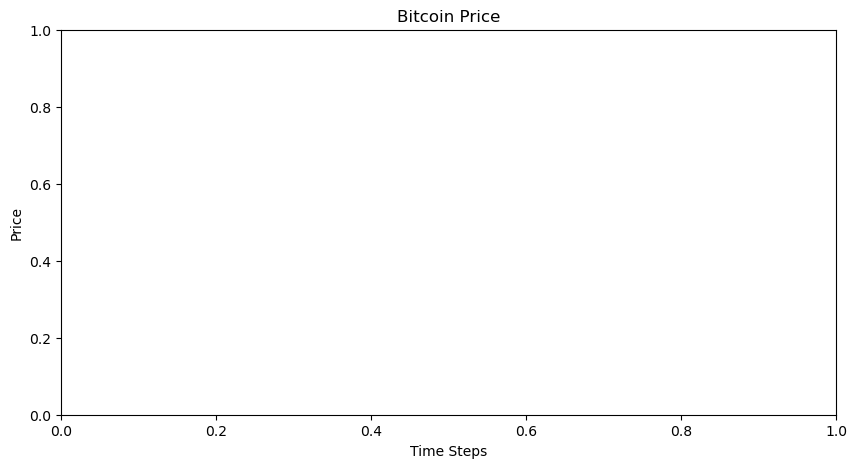

In [ ]:
# plot the data
plt.figure(figsize=(10,5))
plt.title('Bitcoin Price')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.plot(close_btc, label='Bitcoin')
plt.show()